In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np

from Dy_utils.dataclasses import AtomicParameters, SystemParameters
from Dy_utils.level_splittings import construct_B_df
from Dy_utils.master_equation import MasterEquation
from Dy_utils.phonon_process import PhononProcess
from Dy_utils.plotting import plot_rates

### Set Parameters

Define the atomic and system parameters for modeling. Note, both parameter sets have
default float values which can be overwritten.

Available atomic parameters with default values include:
- `v_s`: float = 1/2
- `v_d`: float = 1/2
- `s`: float = 8
- `n_s`: float = 0

Available system parameters with default values include:
- `T`: float = 6.5
- `bias`: float = 1
- `I_o`: float = 18*(10**-12)
- `tipu`: float = 0.1
- `tipd`: float = 0.9
- `surfu`: float = 0.5
- `surfd`: float = 0.5
- `B_x`: float = 0.0
- `B_z`: float = 0.0
- `zeta`: float = 0.65
- `SigmaS`: float = 6.5*(10**-2)
- `pheff`: float = 2*(10**-4)
- `B_20`: float = -5.18416895e-01
- `B_40`: float = 1.04712807e-03
- `B_60`: float = -4.75920969e-07
- `B_63`: float = 0
- `B_66`: float = -0.0000075

In [2]:
atomic_parameters = AtomicParameters(n_s=0)
system_parameters = SystemParameters(B_z=0.06)

### Load B_df
Load the files containing avoided level crossing information. Change the directory above to the location where the csv files are located. It also create the magnetic field sweep file, even if it is not used. It will also scale the tunnel splittings approproately if you change B66 or B63

Check, should output two rows, one for 8m8 and one for 5m5

In [4]:
B_df = construct_B_df(
    directory=Path("level_splittings/4f5d6s_ns0"), 
    filenames=["df_m76.csv", "df_7m6.csv", "df_6m8.csv", "df_m68.csv", "df_m78.csv", "df_7m8.csv", "df_0f.csv"], 
    n_s=atomic_parameters.n_s, 
    sweep_rate=0.033, 
    sweep_num=28, 
    B_63=system_parameters.B_63, 
    B_66=system_parameters.B_66
)

B_df[~B_df.J_z_lower.isna()]

B66 scaling:  1.0


,B_z,level_splitting,rel_time,J_z_lower,lower_ind_values,J_z_upper,upper_ind_values,deltaS
14,-2.503395e-09,0.012954,2.417122e-03,-5.5,7.0,5.5,8.0,12.0
15,-3.576279e-10,0.000004,4.099226e-07,-8.0,3.0,8.0,4.0,18.0


### Pick phonon process

Possible phonon process methods include: `Direct`, `Orbach`, `Raman`

In [5]:
ph = PhononProcess(atomic_parameters, system_parameters)
rat_mat, energy_diff = ph.get_ph_trates(phonon_trates_method="Raman", dos="Debye")

### Master Eqn

In [6]:
meqn = MasterEquation(atomic_parameters, system_parameters)

Electron rates are added to phonon rates. 

Defining `surface_only=True` will only calculate e_SS+sec_el rates.

Keep `sec_el=0` for `surface_only=False`

In [7]:
el_rat_mat = meqn.get_el_trates(rat_mat, sec_el=0, surface_only=False)

/Users/gsblendorio/Documents/GitHub/adatom-spin-dynamics/Dy_utils/energy_difference_utils.py:33: RuntimeWarning: invalid value encountered in divide
  return (self.dE) / (np.exp((self.dE) * self.sys.beta) - 1)
/Users/gsblendorio/Documents/GitHub/adatom-spin-dynamics/Dy_utils/energy_difference_utils.py:36: RuntimeWarning: invalid value encountered in divide
  return (self.dE) / (np.exp((self.dE) * self.sys.beta) - 1)


el_rat_mat contains sum of phonon+electron rates, to add in QTM rates
If you want to calculate phonon+qtm alone, you can add this function up higher as well


In [8]:
el_rat_matQTM = meqn.det_QTM(B_df, el_rat_mat, energy_diff)

       4f_z      5d_z      6s_z     E (meV)
1  7.097431  0.450997  0.451450 -209.758440
2 -7.097413 -0.451005 -0.451460 -209.693435
3  7.999962  0.500000  0.500000 -206.663947
4 -7.999962 -0.500000 -0.500000 -206.590741
5  6.291122  0.355617  0.352963 -203.932268
6 -6.291069 -0.355642 -0.352990 -203.874991
7  5.367346  0.223687  0.215413 -192.514421
8 -5.367260 -0.223727 -0.215457 -192.462916


Determining phonon + electron rates with QTM...


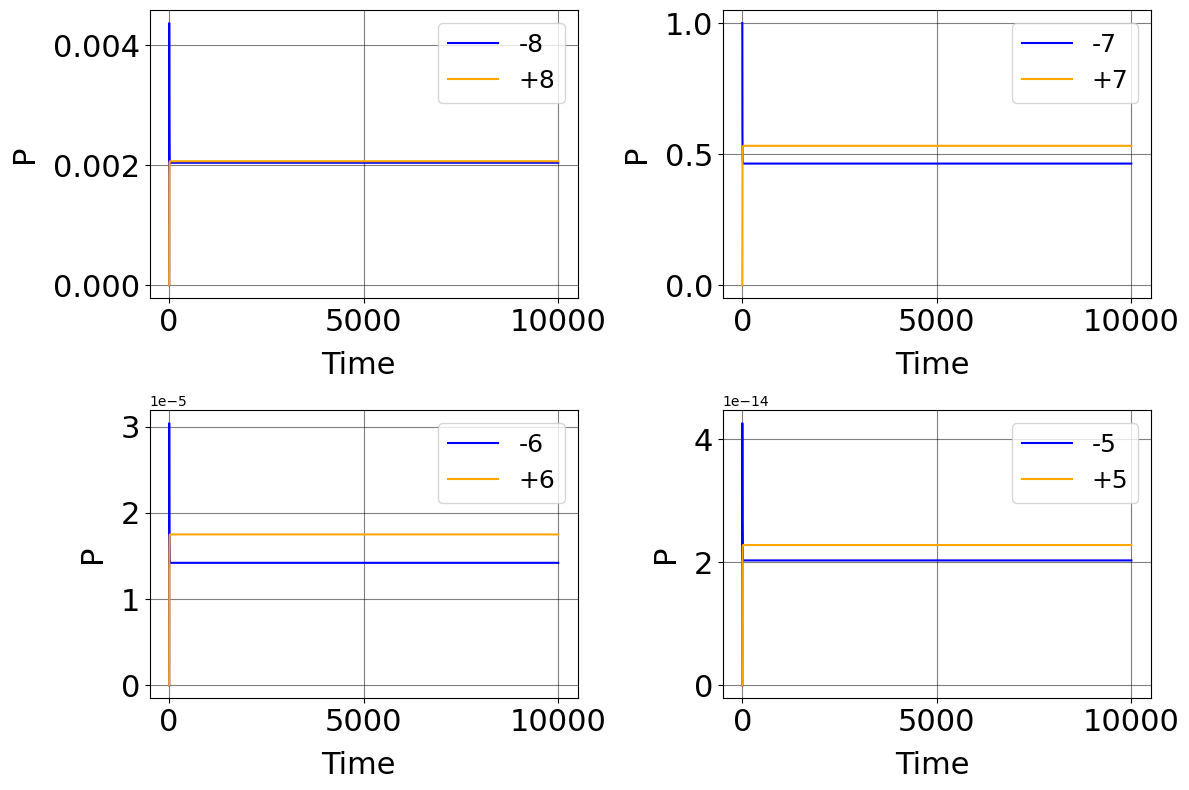

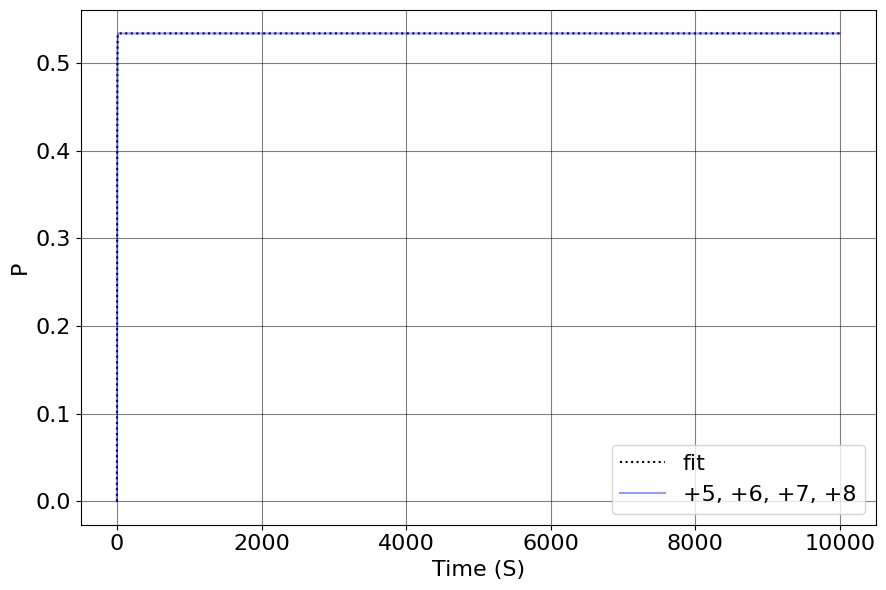

with QTM: 
occ_minus: occ_plus: tau*_el: ln(1/tau):
0.466	0.534	2.31506184761264	-0.839


In [9]:
print('Determining phonon + electron rates with QTM...')
t = np.linspace(0,10**4,10**6)
P = np.zeros((rat_mat.shape[0],))
# P[6:12] = 1/6
P[1] = 1
occ_minus, occ_plus, tau_el, soln = meqn.master(
    P, t, el_rat_matQTM, plot = True, converge_master = True
)

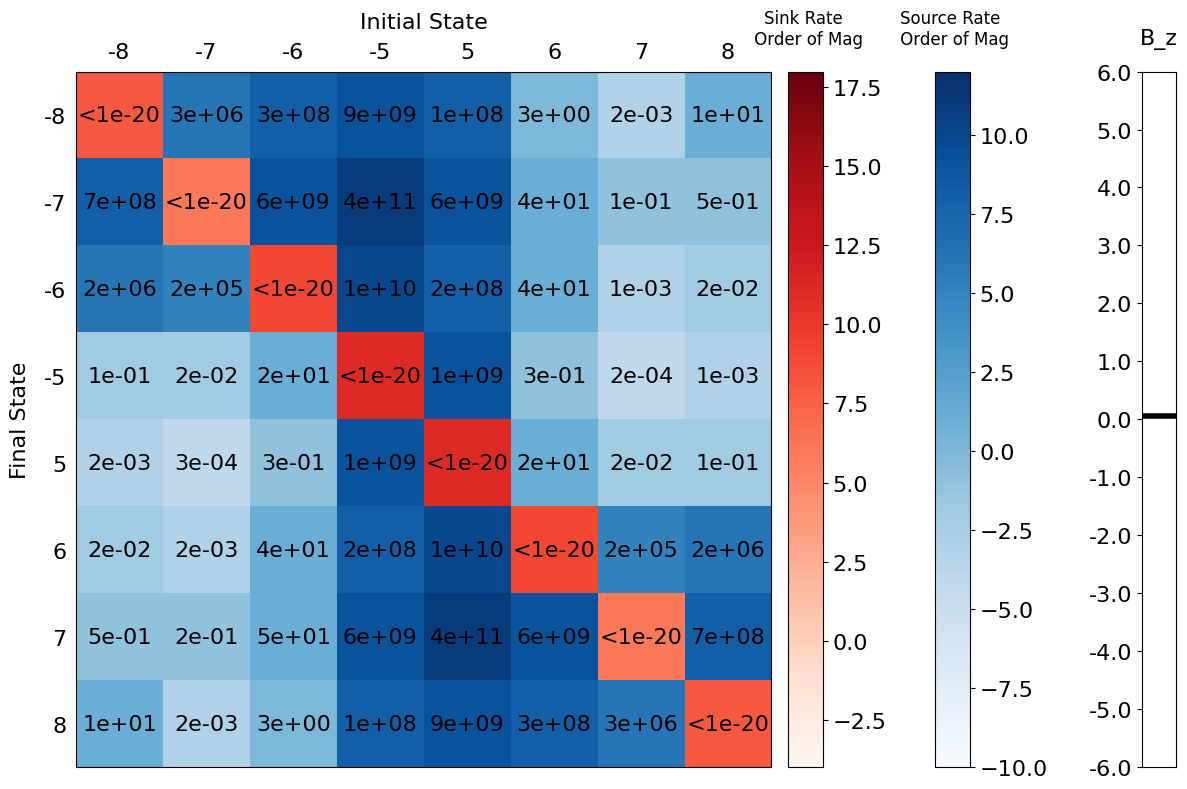

In [10]:
plot_rates(B_z=system_parameters.B_z, rat_mat=el_rat_matQTM, savename="el_rat_matQTM", display=True)